In [9]:
%matplotlib widget

import numpy as np
from sklearn import datasets
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn import svm

Importing Make Circles Datset

In [10]:
X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Non Linear SVM 

Used a Polynomial kernel

In [11]:
def linear_kernel(x1, x2):
    return x1.T @ x2
def poly_kernel(x1, x2, d = 2, c = 0):
    return (x1 @ x2.T + c)**d

class svm():
    def __init__(self, kernel='poly', c=1.0, tol=1e-3, maxiter=100):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        
#         if self._kernel == 'linear':
#             self._k = linear_kernel
        if self._kernel == 'poly':
            self._k = poly_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'poly':
            self._weights = np.random.rand(self._data.shape[1])
        

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
#         if self._kernel == 'linear':
#             u = self._weights @ x.T - self._b
#         else:
        if self._kernel == 'poly':
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return 0 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

Trained the model using above Non Linear SVM

[0.78010363 0.08435972]
4.479930864513921
accuracy 100.0


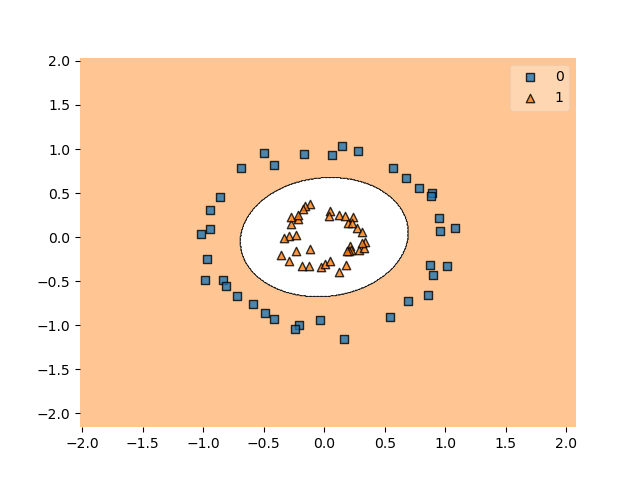

In [12]:
model = svm(c=5.0)
model.fit(X_train, y_train)
print(model._weights)
print(model._b)

fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, model)
fig.add_subplot(ax)

y_pred = model.predict(X_test)
# print(y_pred)
for i in range (len(y_pred)):
    if y_pred[i] == -1:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
# y_pred1 = np.where(y_pred== 1 , 0 , y_pred) 
# print(y_pred, y_test)
acc = accuracy_score(y_test, y_pred )*100
print("accuracy", acc)

We see that we get an accuracy of 100% using non linear SVM

Imported SVM from sklearn and implemented linear and poly for both

accuracy 68.0


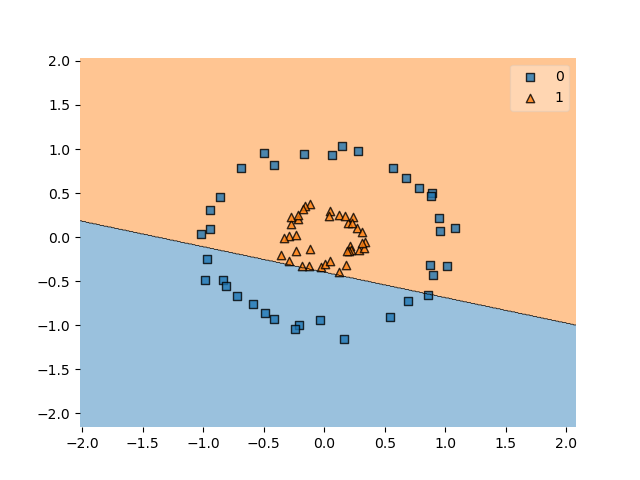

In [13]:
from sklearn import svm
clf = svm.SVC(kernel="linear", C=5)
clf.fit(X_train, y_train)
fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, clf)
fig.add_subplot(ax)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred )*100
print("accuracy", acc)

We see that we get an accuracy of 68 using linear SVM

accuracy 100.0


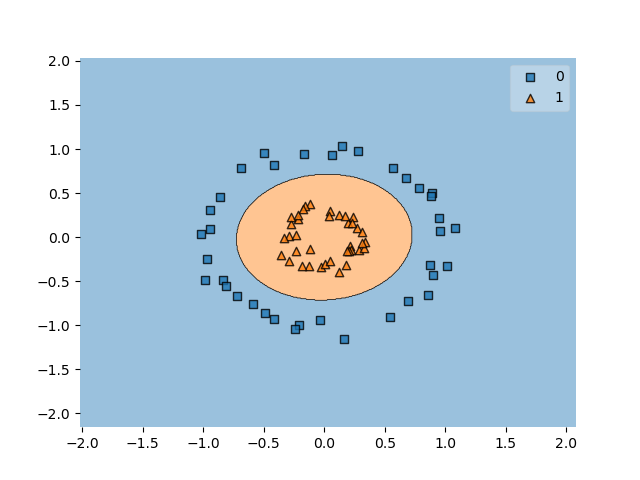

In [7]:
clf = svm.SVC(kernel="poly",degree = 2)
clf.fit(X_train, y_train)
fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, clf)
fig.add_subplot(ax)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred )*100
print("accuracy", acc)

We get an accuracy of 100 using polynomial kernel

We see that from the polynomial kernel we made form scratch we receive an accuracy of 100 and from the one imported from 
sklearn linear gives an accuracy of 68 and polynomial gives and accuracy of 100.

# Multi Class SVM

Loading Iris Dataset

In [14]:
iris = datasets.load_iris()
X,y = iris.data, iris.target

In [15]:
def linear_kernel(x1, x2):
    return x1.T @ x2
def poly_kernel(x1, x2, d = 2, c = 0):
    return (x1 @ x2.T + c)**d


class multi_svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=50):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel == 'poly':
            self._k = poly_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

0 vs rest [SETOSA]

In [16]:
y1=[]
for i in range(len(y)):
    if(y[i] != 0):
        y1.append(1)
    else:
        y1.append(0)
y1 = np.array(y1)
print(y1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


splitting dataset into 90-10
for all the dataset below we are considering 1 vs all like Setosa vs other two, versicolor vs other 2.
we will first use linear and polynomial kernel from multiclass_svm created from scratch and then compare it with linear and poly kernel from SVM imported from sklearn.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.1, random_state = 42)

In [18]:
clf = multi_svm(kernel = 'linear')

clf.fit(X_train, y_train)
#print(clf._weights)
print(clf._b)
y_pred = clf.predict(X_test)
print(y_pred)
for i in range (len(y_pred)):
    if y_pred[i] == -1:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
print(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)
print(acc*100)

[DEBUG] smo_step: eta = 0.0


UnboundLocalError: local variable 'a2' referenced before assignment

getting error a2 referenced before assignment as told by professor, we will ignore it for linear cases.

In [19]:
clf = multi_svm(kernel = 'poly')

clf.fit(X_train, y_train)
#print(clf._weights)
print(clf._b)
y_pred = clf.predict(X_test)
print(y_pred)
for i in range (len(y_pred)):
    if y_pred[i] == -1:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
print(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)
print(acc*100)

2586.3495300911823
[ 1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.] [1 0 1 1 1 0 1 1 1 1 1 0 0 0 0]
93.33333333333333


In [20]:
model = svm.SVC(kernel = 'linear')
model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)*(100)
print("accuracy", acc)

[[ 0.04631136 -0.52105578  1.0030165   0.46411816]]
[-1.45338269]
accuracy 100.0


In [21]:
model = svm.SVC(kernel = 'poly')
model.fit(X_train, y_train)
# print(model.coef_)
print(model.intercept_)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)*(100)
print("accuracy", acc)

[-1.13450738]
accuracy 100.0


We get an accuracy of 93 when we use the method made from scratch and 100 when we import svm, this may be because setosa samples are linearly seperable.

1 vs rest (VIRGINCA)

In [22]:
y2=[]
for i in range(len(y)):
    if(y[i] == 1):
        y2.append(0)
    else:
        y2.append(1)
y2 = np.array(y2)
print(y2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size = 0.1, random_state = 42)

In [38]:
clf = multi_svm(kernel = 'poly')

clf.fit(X_train, y_train)
#print(clf._weights)
print(clf._b)
y_pred = clf.predict(X_test)
print(y_pred)
for i in range (len(y_pred)):
    if y_pred[i] == -1:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
print(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)
print(acc*100)

431269.76340000005
[-1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 0 1 1 1 1 0 1 1 0 1 1 1 1]
13.333333333333334


In [25]:
model = svm.SVC(kernel = 'linear')
model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)*(100)
print("accuracy", acc)

[[-0.10886609  2.11282312 -0.44951812  1.33640535]]
[-4.93269427]
accuracy 80.0


In [26]:
model = svm.SVC(kernel = 'poly')
model.fit(X_train, y_train)
# print(model.coef_)
print(model.intercept_)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)*(100)
print("accuracy", acc)

[-1.07825882]
accuracy 100.0


we get an accuracy of 13% on the model made form scratch and an accuracy of 100 and 93 respectively using linear and poly SVM imported from sklearn

2 vs rest (VERSICOLOR)

In [35]:
y3=[]
for i in range(len(y)):
    if(y[i] == 2):
        y3.append(0)
    else:
        y3.append(1)
y3 = np.array(y3)
print(y3)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size = 0.1, random_state = 42)

In [37]:
clf = multi_svm(kernel = 'poly')

clf.fit(X_train, y_train)
#print(clf._weights)
print(clf._b)
y_pred = clf.predict(X_test)
print(y_pred)
for i in range (len(y_pred)):
    if y_pred[i] == -1:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
print(y_pred, y_test)
acc = accuracy_score(y_pred, y_test)
print(acc*100)

431269.76340000005
[-1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 0 1 1 1 1 0 1 1 0 1 1 1 1]
13.333333333333334


In [30]:
model = svm.SVC(kernel = 'linear')
model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)*(100)
print("accuracy", acc)

[[ 0.61511817  1.13966056 -2.01106294 -1.78632244]]
[5.67440946]
accuracy 100.0


In [31]:
model = svm.SVC(kernel = 'poly')
model.fit(X_train, y_train)
# print(model.coef_)
print(model.intercept_)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)*(100)
print("accuracy", acc)

[2.15385055]
accuracy 93.33333333333333


we get an accuracy of 13.33  on the model made by me from scratch(multi_svm) and 100 and 93 respectively on linear and poly svm imported from sklearn

Our Model is not that good in every case we can see. The SVM imported from sklearn is performing better in each case. 
Surprisingly, linear SVM(imported from sklearn) is performing better for every case(accuracy of 100%). 